# Demo: Predicting Citibike Trips Using Snowflake & Facebook Prophet

### 0. Prerequisites

Make sure to install the following dependencies. 

<div class="alert alert-info"><h4>Note</h4><p>Only run the cell below the first time you run this notebook in SageMaker</p></div>


To install the depedencies, select the cell below, change its type to 'code' from the menu above and then run it.

***IMPORTANT: Make sure to restart the kernal before you move forward***

### 1. Load the Credentials


In [1]:
import json

with open('creds_jr.json') as f:
    data = json.load(f)
    username = data['username']
    password = data['password']

### 2. Load data
We first create a connection to our Snowflake account by specifying the auth details as well as the DB, schama and warehouse we want to use.

In [2]:
import snowflake.connector
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

**Note**: Please change the `SF_ACCOUNT` and `SF_WH` variables below to your account & warehouse.

In [3]:
SF_ACCOUNT = 'oh_demo22.us-east-2.aws'
SF_WH = 'LAB_WH'
SF_USERNAME = username
SF_PWD = password

# Connecting to Snowflake using the default authenticator
ctx = snowflake.connector.connect(
  user=SF_USERNAME,    #username,
  password=SF_PWD,    #password,
  account=SF_ACCOUNT,
  warehouse=SF_WH,
  database='CITIBIKE',
  schema='demo' #not PUBLIC
)

Lets summarize trips to daily resolution and inspect the first five rows

In [4]:
cur=ctx.cursor()

# Lets aggregate the metering data for Dominion Power up to the day level
#sql = "select date_trunc('day', STARTTIME), count(*) from trips_vw" +\
#        " group by date_trunc('day', STARTTIME)" +\
#        " order by date_trunc('day', STARTTIME)"
sql = "select date_trunc('day', STARTTIME), sum(1) " +\
       " from trips" +\
       " WHERE STARTTIME < '2020-01-01' " +\
       " group by date_trunc('day', STARTTIME)" +\
       " order by date_trunc('day', STARTTIME)"

cur.execute(sql)

# Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
df = cur.fetch_pandas_all()
# The FB Prophet library expects the data to be in two columns: 'ds' for timestamp and 'y' for the value
df.columns=['ds', 'y']
df.head(5)
df.tail(5)

,ds,y
2392,2019-12-27,32535
2393,2019-12-28,29097
2394,2019-12-29,18321
2395,2019-12-30,12465
2396,2019-12-31,32226


The Facebook Prophet library [https://facebook.github.io/prophet/] expects two columns as input: `ds` (timestamp) and `y` (the value we are trying to predict).

Lets look at how many total records we have at the daily interval:

In [5]:
df.count()

ds    2397
y     2397
dtype: int64

### 3. Train the model

Now that we have the data in the right format, lets train our time series model using Facebook Prophet:

In [6]:
#m = Prophet()
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 6 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### 4. Inference & Visualization

Using a FB Prophet helper function, lets create a dataframe that will hold our predictions and then make predictions for the next two years.

In [7]:
future = m.make_future_dataframe(periods=730)
future.tail()

,ds
3122,2021-12-26
3123,2021-12-27
3124,2021-12-28
3125,2021-12-29
3126,2021-12-30


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3122,2021-12-26,42528.602753,29596.698181,55410.942202
3123,2021-12-27,49397.528759,36762.782271,61989.771980
3124,2021-12-28,51562.129289,38593.639219,64757.128936
3125,2021-12-29,52718.589931,40144.441000,65216.852157
3126,2021-12-30,51444.337540,38024.150336,64740.057623


We will now plot the forecast along with our historical data

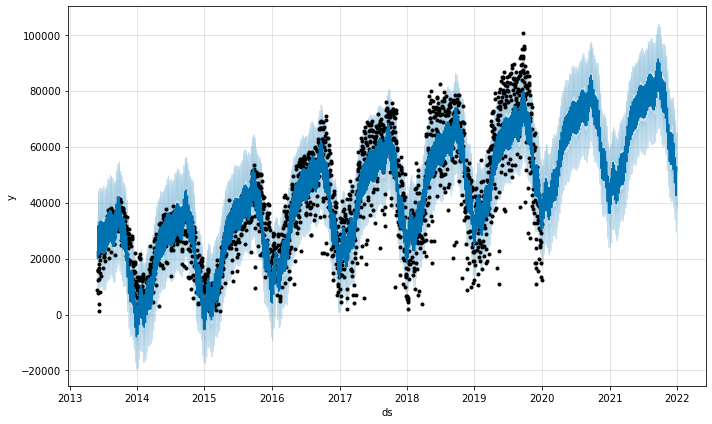

In [9]:
fig1 = m.plot(forecast)

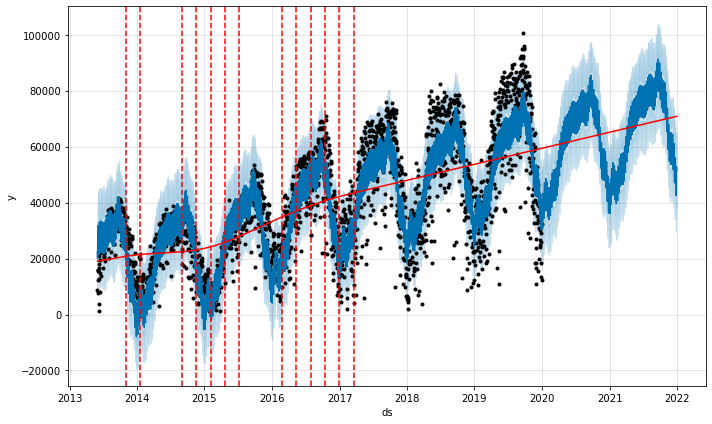

In [10]:
fig1a = m.plot(forecast)
a = add_changepoints_to_plot(fig1a.gca(),m,forecast)

To see the seasonality of the data, lets plot the components that will show how our data changes yearly, weekly and its overall trend.

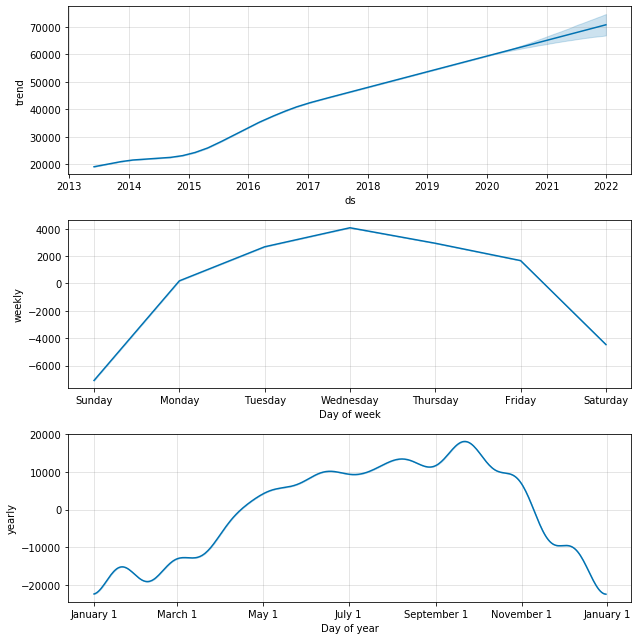

In [11]:
fig2 = m.plot_components(forecast)

### 4. Write the predictions back into Snowflake

First, lets create a new table that will hold the predictions

In [12]:
# Connecting to Snowflake using the default authenticator
ctx = snowflake.connector.connect(
  user=SF_USERNAME, #username,
  password=SF_PWD, #password,
  account=SF_ACCOUNT,
  warehouse=SF_WH,
  database='CITIBIKE',
  schema='DEMO'
)

cur=ctx.cursor()

# create a new table to hold the batch predictions
sql = "CREATE TABLE IF NOT EXISTS TRIPS_FORECAST (" +\
        "model_id varchar(100)," +\
        "ds timestamp, " +\
        "yhat float, " +\
        "yhat_lower float, " +\
        "yhat_upper float)"
cur.execute(sql)

ctx.close()

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.2.8, Python Version: 3.7.6, Platform: Linux-4.19.121-linuxkit-x86_64-with-debian-buster-sid
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO:snowflake.connector.cursor:query: [CREATE TABLE IF NOT EXISTS TRIPS_FORECAST (model_id varchar(100),ds timestamp, y...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.connection:closed


Now insert all the records available in the Pandas data frame.

In [13]:
    import time
    start_time = time.time()

    from datetime import datetime
    now = datetime.now()
    model_id = now.strftime("MPre2020_%Y%m%d_%H%M%S")
    
    con = snowflake.connector.connect(
          user=SF_USERNAME,
          password=SF_PWD,
          account=SF_ACCOUNT,
          warehouse=SF_WH,
          database='CITIBIKE',
          schema='DEMO'
        )
    try:
        sql = "INSERT INTO TRIPS_FORECAST VALUES "
        count = 0
        for index, row in forecast.iterrows():
            count += 1
            sql += "('" +model_id+"', '" + str(row['ds']) + "', " + str(row['yhat']) + ", " + str(row['yhat_lower']) + ", " + str(row['yhat_upper']) + ")"
            if (count % 10000 == 0):
                con.cursor().execute(sql)
                print("Flushing 10000 records: ", count)
                sql = "INSERT INTO TRIPS_FORECAST VALUES "
            else:
                if count < len(forecast):
                    sql += ","

        print("Total records: ", count)
        con.cursor().execute(sql)
    finally:
        con.close()
        print("--- %s seconds ---" % (time.time() - start_time))
    #print(sql)

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.2.8, Python Version: 3.7.6, Platform: Linux-4.19.121-linuxkit-x86_64-with-debian-buster-sid
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO:snowflake.connector.cursor:query: [INSERT INTO TRIPS_FORECAST VALUES ('MPre2020_20201221_161723', '2013-06-01 00:00...]


Total records:  3127


INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.connection:closed


--- 3.4121387004852295 seconds ---
